#### 背景说明

识别道路上的车道是所有司机的共同任务，以确保车辆在驾驶时处于车道限制之内，并减少因越过车道而与其他车辆发生碰撞的机会。对自动驾驶汽车来说，这同样也是一项关键任务。事实证明，使用计算机视觉技术识别道路上的车道标记是可能的。

#### 示例数据

数据为车道图像，如下图所示：
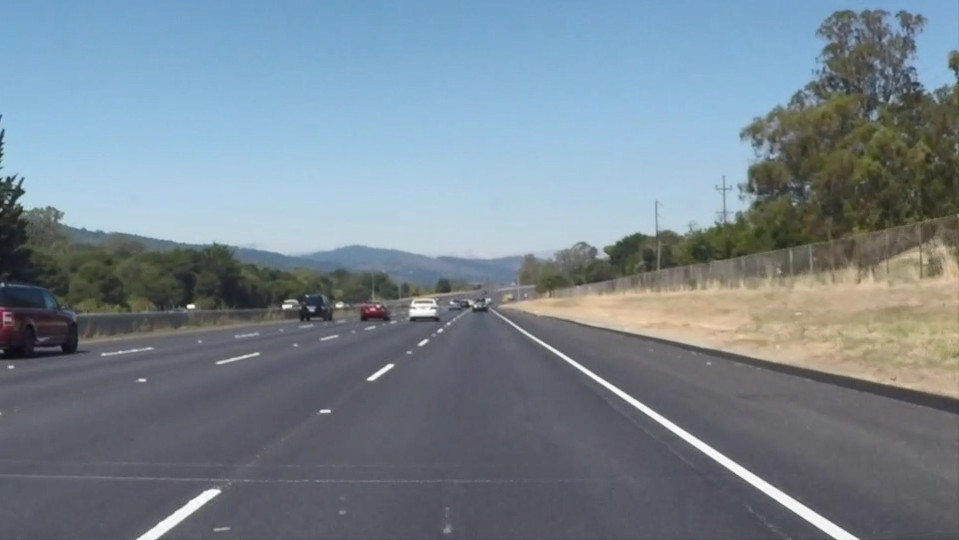
#### 分析思路
要检测出当前车道，就是要检测出左右两条车道直线。由于无人车一直保持在当前车道，那么无人车上的相机拍摄的视频中，车道线的位置应该基本固定在某一个范围内：
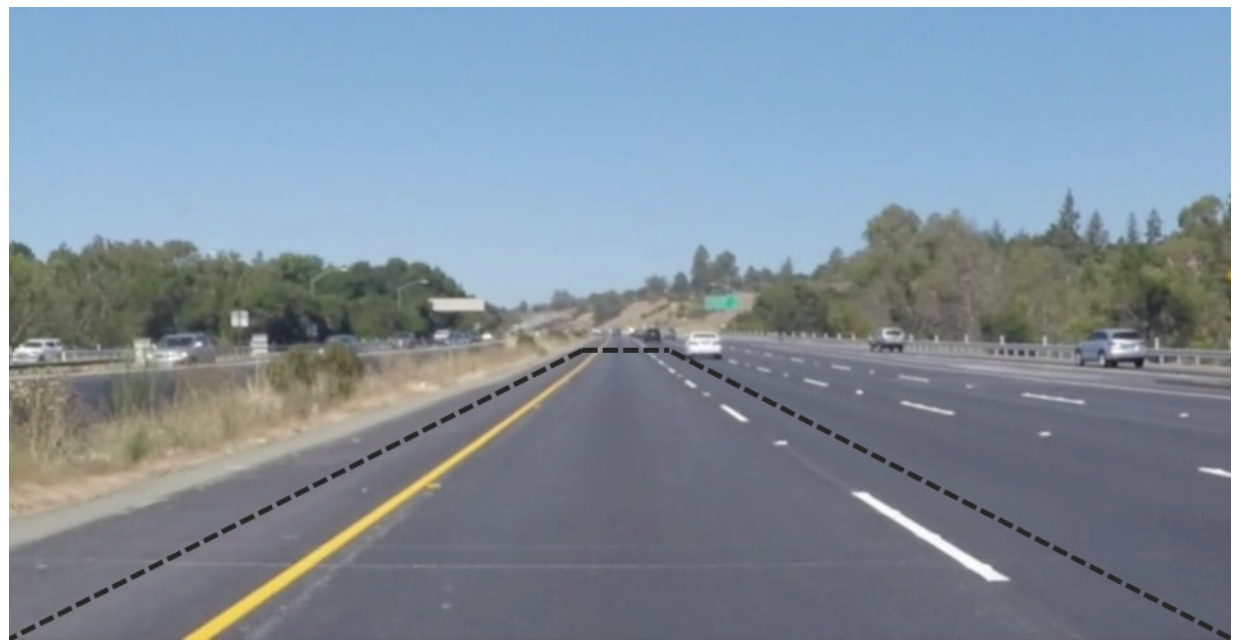
如果我们手动把这部分ROI区域抠出来，就会排除掉大部分干扰。接下来检测直线肯定是用霍夫变换，但ROI区域内的边缘直线信息还是很多，考虑到只有左右两条车道线，一条斜率为正，一条为负，可将所有的线分为两组，每组再通过均值或最小二乘法拟合的方式确定唯一一条线就可以完成检测。总体步骤如下：<br>



1.灰度化<br>
2.高斯模糊<br>
3.Canny边缘检测<br>
4.不规则ROI区域截取<br>
5.霍夫直线检测<br>
6.车道计算<br>
前面通过霍夫变换得到了多条直线的起点和终点，我们的目的是通过某种算法只得到左右两条车道线。<br>
（1）根据斜率正负划分某条线是左车道还是右车道。<br>
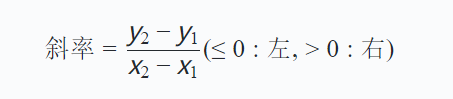
斜率计算是在图像坐标系下，所以斜率正负/左右跟平面坐标有区别。<br>
（2）迭代计算各直线斜率与斜率均值的差，排除掉差值过大的异常数据。<br>
注意这里迭代的含义，意思是第一次计算完斜率均值并排除掉异常值后，再在剩余的斜率中取均值，继续排除……这样迭代下去。<br>
（3）最小二乘法拟合左右车道线。<br>
经过第（2）步的筛选，就只剩下可能的左右车道线了，这样只需从多条直线中拟合出一条就行。拟合方法有很多种，最常用的便是最小二乘法，它通过最小化误差的平方和来寻找数据的最佳匹配函数。<br>
具体来说，假设目前可能的左车道线有6条，也就是12个坐标点，包括12个x和12个y，我们的目的是拟合出这样一条直线：<br>
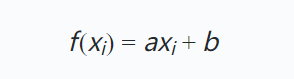
使得误差平方和最小：<br>
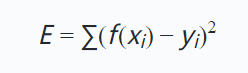

In [1]:
#在本地终端ssh外网地址
# 后台运行jupyter，避免中途退出
# nohup jupyter notebook > /dev/null 2>&1 &
# jobs # 测试
# 然后输入外网IP，通过8888端口访问jupyter，密码123456

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 高斯滤波核大小
blur_ksize = 5

# Canny边缘检测高低阈值
canny_lth = 50
canny_hth = 150

# 霍夫变换参数；这种参数一般都会给好
rho = 1
theta = np.pi / 180
threshold = 15
min_line_len = 40
max_line_gap = 20

In [2]:
def process_an_image(img):
    ## 1. 灰度化、滤波和Canny
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 1) # 高斯滤波
    edges = cv2.Canny(blur_gray, canny_lth, canny_hth) # canny算子

    # 2. 标记四个坐标点用于ROI截取
    rows, cols = edges.shape
    points = np.array([[(0, rows), (460, 325), (520, 325), (cols, rows)]])
    # [[[0 540], [460 325], [520 325], [960 540]]]
    roi_edges = roi_mask(edges, points) ##

    # 3. 霍夫直线提取
    drawing, lines = hough_lines(roi_edges, rho, theta,   ##
                                 threshold, min_line_len, max_line_gap)

    # 4. 车道拟合计算
    draw_lanes(drawing, lines)

    ## 5. 原始图像和drawing图像将按照0.9和0.2的比例混合在一起
    result = cv2.addWeighted(img, 0.9, drawing, 0.2, 0)

    return result

In [3]:
def roi_mask(img, corner_points):
    # 创建掩膜
    mask = np.zeros_like(img) ##
    cv2.fillPoly(mask, corner_points, 255)

    masked_img = cv2.bitwise_and(img, mask) ##
    return masked_img

In [4]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    ## 统计概率霍夫直线变换
    lines = cv2.HoughLinesP(img, rho, theta, threshold,
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    ## 新建一副空白画布
    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # 画出直线检测结果
    # draw_lines(drawing, lines)

    return drawing, lines

In [5]:
def draw_lines(img, lines, color=[0, 0, 255], thickness=1):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness) ##

In [6]:
def draw_lanes(img, lines, color=[255, 0, 0], thickness=8):
    # a. 划分左右车道
    left_lines, right_lines = [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            k = (y2 - y1) / (x2 - x1) # 斜率，用于判断是左边还是右边
            if k < 0:
                left_lines.append(line)
            else:
                right_lines.append(line)

    if (len(left_lines) <= 0 or len(right_lines) <= 0):
        return

    # b. 清理异常数据
    clean_lines(left_lines, 0.1)
    clean_lines(right_lines, 0.1)

    # c. 得到左右车道线点的集合，拟合直线
    left_points = [(x1, y1) for line in left_lines for x1, y1, x2, y2 in line]
    left_points = left_points + [(x2, y2)
                                 for line in left_lines for x1, y1, x2, y2 in line]

    right_points = [(x1, y1)
                    for line in right_lines for x1, y1, x2, y2 in line]
    right_points = right_points + \
        [(x2, y2) for line in right_lines for x1, y1, x2, y2 in line]

    left_results = least_squares_fit(left_points, 325, img.shape[0])
    right_results = least_squares_fit(right_points, 325, img.shape[0])

    # 注意这里点的顺序；其实就是按逆时针指定了梯形的四角坐标
    vtxs = np.array(
        [[left_results[1], left_results[0], right_results[0], right_results[1]]])
    # d.填充车道区域
    cv2.fillPoly(img, vtxs, (0, 255, 0))

    # 或者只画车道线
    # cv2.line(img, left_results[0], left_results[1], (0, 255, 0), thickness)
    # cv2.line(img, right_results[0], right_results[1], (0, 255, 0), thickness)

In [7]:
def clean_lines(lines, threshold):
    # 迭代计算斜率均值，排除掉与差值差异较大的数据
    slope = [(y2 - y1) / (x2 - x1)
             for line in lines for x1, y1, x2, y2 in line]
    while len(lines) > 0:
        mean = np.mean(slope)
        diff = [abs(s - mean) for s in slope]
        idx = np.argmax(diff)
        if diff[idx] > threshold:
            slope.pop(idx)
            lines.pop(idx)
        else:
            break

In [8]:
def least_squares_fit(point_list, ymin, ymax):
    # 最小二乘法拟合
    x = [p[0] for p in point_list]
    y = [p[1] for p in point_list]

    ## polyfit第三个参数为拟合多项式的阶数，所以1代表线性；这边表示用y去拟合x
    fit = np.polyfit(y, x, 1)
    fit_fn = np.poly1d(fit)  # 获取拟合的结果：x=ay+b

    xmin = int(fit_fn(ymin))
    xmax = int(fit_fn(ymax))

    return [(xmin, ymin), (xmax, ymax)] # 通过这两个点坐标就能拟合出一条直线

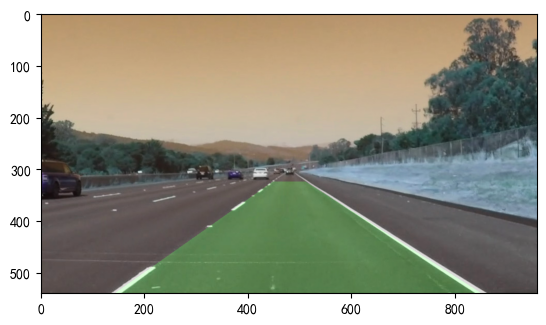

In [9]:
if __name__ == "__main__":
    img = cv2.imread('2.jpg')
    result = process_an_image(img)
    plt.imshow(result)
    plt.show()
#     cv2.imshow("lane", img)
#     cv2.imshow("result", result)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

